In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from fedland.utils import load_all_training_results, get_experiment_description, plot_results_overview, plot_client_info

In [107]:
def plot_residuals(y_pred: pd.Series, residuals: pd.Series):
    # Seaborn Q-Q plot using a histogram to check normality of residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, stat="density", color="grey", label="Residuals", bins=30)

    mean_residuals = residuals.mean()
    std_residuals = residuals.std()
    x_values = np.linspace(residuals.min(), residuals.max(), 1000)
    normal_dist = (1 / (std_residuals * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean_residuals) / std_residuals) ** 2)

    plt.plot(x_values, normal_dist, 'k', linewidth=2, label="Normal Distribution")

    plt.title("Histogram of Residuals with Normal Distribution Curve")
    plt.legend()
    plt.show()

    # Scatter
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, color='grey', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Scatter Plot of Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    
    # Line
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, marker='o', color='grey', linestyle='-', alpha=0.7, label="Residuals")
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residuals in Order (Autocorrelation Check)")
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.legend()
    plt.show()

## Analyze Generalizability
Things tried:
- Validation Acc alone and (train acc - test acc)
- Validation Loss and (train loss - test loss)
TODO:
- Pull in gini index and other client level stats

In [108]:
df = load_all_training_results(results_path="../results", ignore_validate=True)
# df = df[df["client_count"] != 3]
df = df[df["experiment_id"] != "9a0fe8d3-8506-4157-ab61-291fc6d9c38d"]
df = df[df["experiment_id"] != "a97f0e29-0262-4eb9-a117-f08f25a3a2b1"]
df = df[df["experiment_id"] != "bb3aa1b6-db01-4610-9689-9d0101e92d17"]
df = df[df["experiment_id"] != "e6c4fbe6-b338-4ddb-9994-eb3097535278"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21500 entries, 0 to 23209
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        21500 non-null  int64         
 1   epoch                        21500 non-null  int64         
 2   learning_rate                21500 non-null  float64       
 3   batch_size                   21500 non-null  int64         
 4   len_train_indices            21500 non-null  int64         
 5   len_test_indices             21500 non-null  int64         
 6   momentum                     21500 non-null  float64       
 7   train_loss                   21500 non-null  float64       
 8   train_accuracy               21500 non-null  float64       
 9   test_loss                    21500 non-null  float64       
 10  test_accuracy                21500 non-null  float64       
 11  path_norm                    21500 non-null  f

In [109]:
# Filter and check results in early training
# temp_filter = df.groupby("experiment_id")["iteration"].transform("max") * 0.10
# df = df[df["iteration"] <= temp_filter]
# df.info()

In [210]:
# df_last_epoch = df.loc[df.groupby("experiment_id")["epoch"].idxmax()]
df_train = df.copy()
df_train = df_train[df_train.groupby("experiment_id")["epoch"].transform("max") == df_train["epoch"]]
df_train["iteration^2"] = df_train["iteration"] ** 2
df_train["iteration_log"] = np.log(df_train["iteration"] + 1)
df_train["pct_change_path_norm_round"] = (
    (df_train["path_norm"] - df_train["global_path_norm"]) / df_train["global_path_norm"].abs()
)
df_train["is_iid"] = df_train["gini_index"] < 0.05
df_train["is_iid"] = df_train["is_iid"].astype(int)
is_balanced = df_train.groupby("experiment_id")["data_count"].nunique() == 1
df_train["is_balanced"] = df_train["experiment_id"].map(is_balanced)
df_train["is_balanced"] = df_train["is_balanced"].astype(int)
# df_train["data_count"] = (df_train["data_count"] - df_train["data_count"].min()) / (df_train["data_count"].max() - df_train["data_count"].min())
df_train["test_accuracy"] = df_train["test_accuracy"] / 100

df_train["experiment_id"] = df_train["experiment_id"].astype("category")
df_train["client_index"] = df_train["client_index"].astype("category")
df_train["client_count"] = df_train["client_count"].astype("category")

# df_train = df_train[df_train["iteration"] < 20] # NOTE checking the first 20 iterations
print(df_train.shape)
df_train[["test_accuracy", "data_count", "gini_index", "path_norm", "pct_change_path_norm", "pct_change_path_norm_round", "iteration"]].describe()

(5030, 31)


test_accuracy    data_count   gini_index    path_norm  \
count    5030.000000   5030.000000  5030.000000  5030.000000   
mean        0.730332  11528.805169     0.190312   511.414359   
std         0.077540   7176.149940     0.260640   694.669497   
min         0.240000    500.000000     0.007672     7.592847   
25%         0.698000   7500.000000     0.014540   116.618935   
50%         0.749500  10000.000000     0.020280   267.877646   
75%         0.776000  10000.000000     0.493296   672.012630   
max         0.890500  25000.000000     0.707980  5260.832634   

       pct_change_path_norm  pct_change_path_norm_round    iteration  
count           5030.000000                 5030.000000  5030.000000  
mean               0.011557                    0.127098   112.711730  
std                0.023806                    1.310700    86.450408  
min               -0.056915                   -0.972009     3.000000  
25%               -0.001236                   -0.417798    42.000000  
50%                0.005297                    0.010578    81.000000  
75%                0.015079                    0.071671   185.000000  
max                0.288295                   12.357964   300.000000

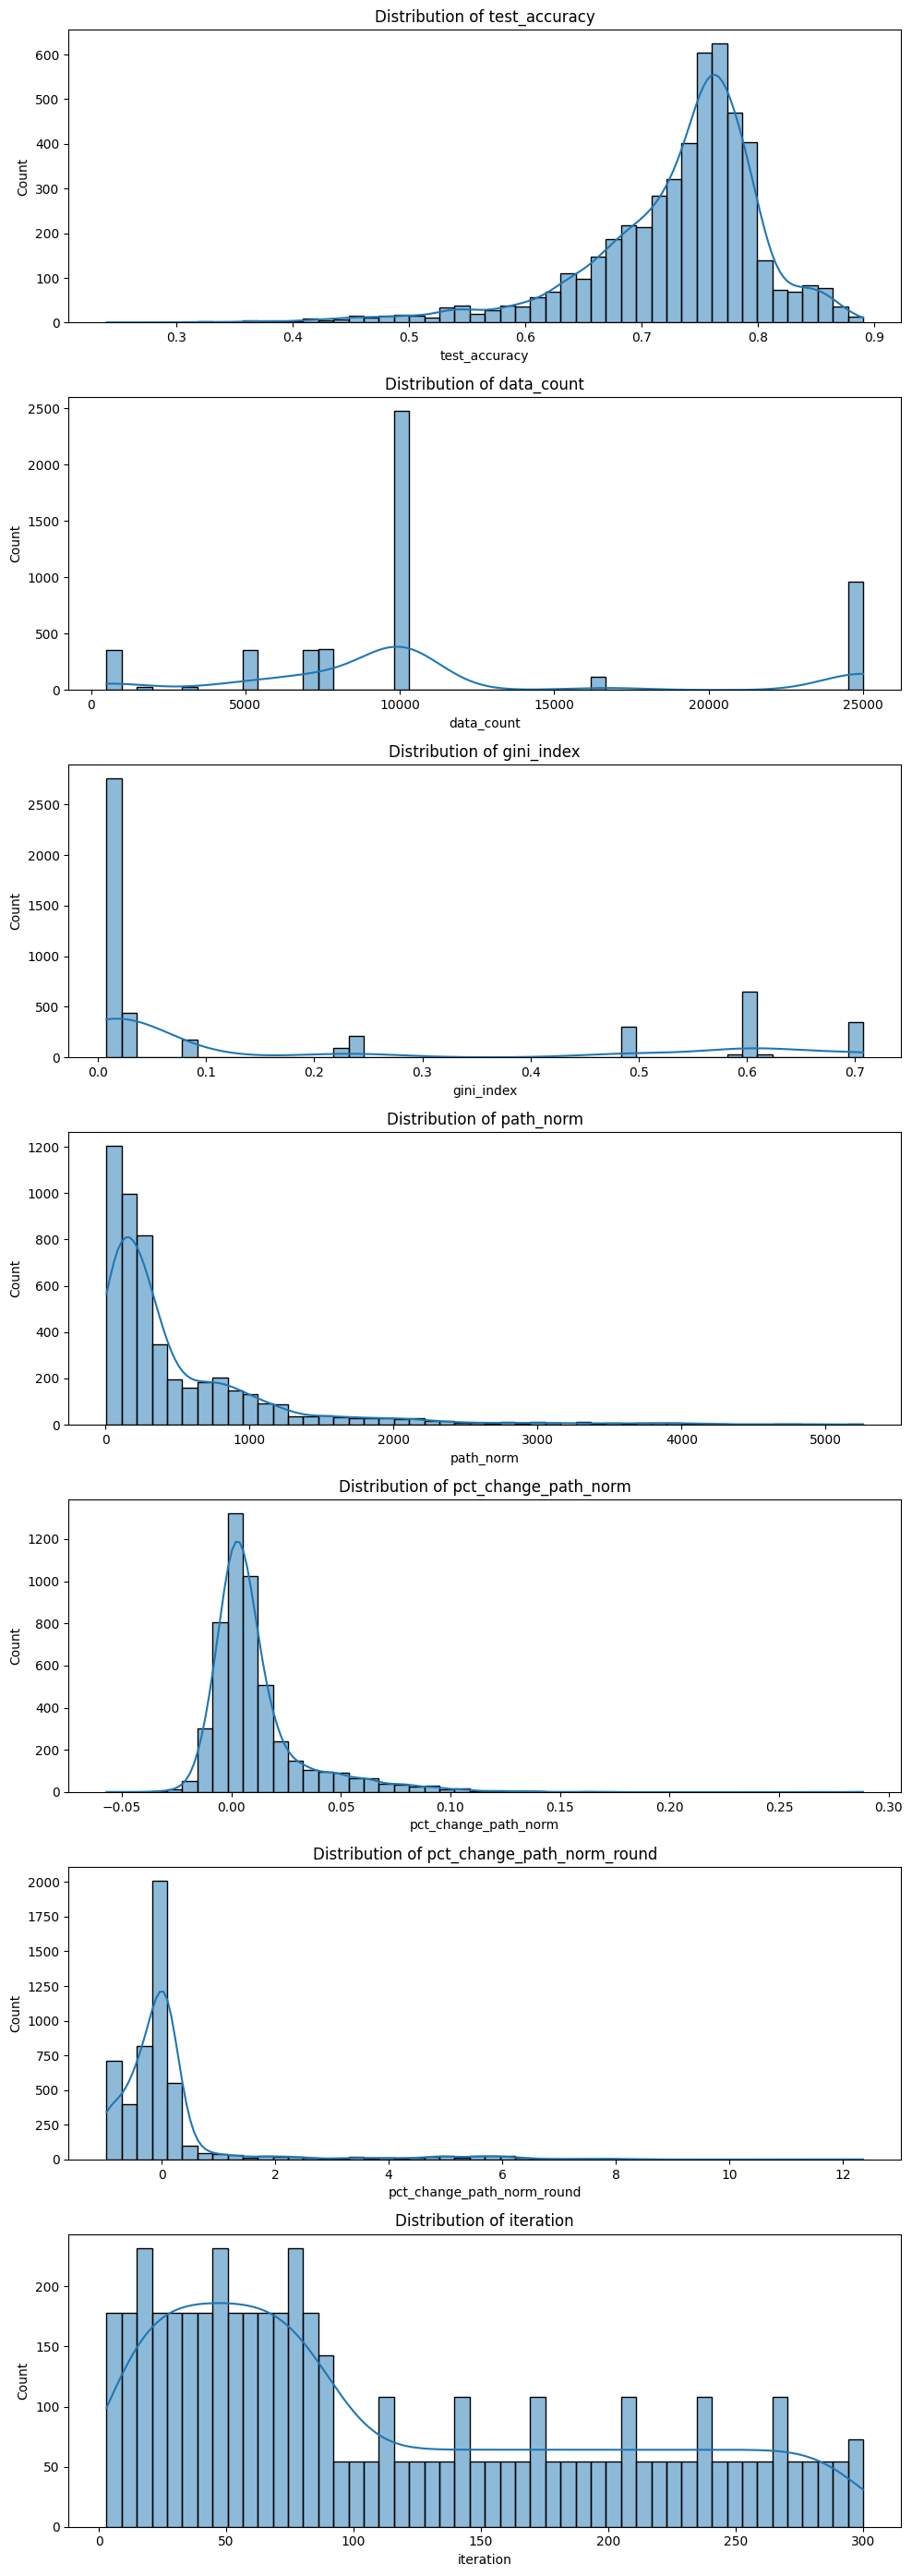

In [211]:
numerical_columns = ["test_accuracy", "data_count", "gini_index", "path_norm", "pct_change_path_norm", "pct_change_path_norm_round", "iteration"]

fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(10, len(numerical_columns) * 4))
for ax, column in zip(axes, numerical_columns):
    sns.histplot(df_train[column], kde=True, ax=ax, bins=50)
    ax.set_title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

In [222]:
x_vars = ["pct_change_path_norm", "is_iid", "is_balanced", "model", "client_count", "aggregator", "iteration"]
# Y = "test_accuracy"
Y = "test_loss"

X = pd.get_dummies(df_train[x_vars], columns=["aggregator", "model", "client_count"], drop_first=True, dtype=int)
X = sm.add_constant(X)
y = df_train[Y]

model = sm.OLS(y, X).fit()
print(f"Y variable = {Y}")
print(model.summary())

Y variable = test_loss
                            OLS Regression Results                            
Dep. Variable:              test_loss   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     611.5
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:40:57   Log-Likelihood:                -2915.8
No. Observations:                5030   AIC:                             5850.
Df Residuals:                    5021   BIC:                             5908.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const    

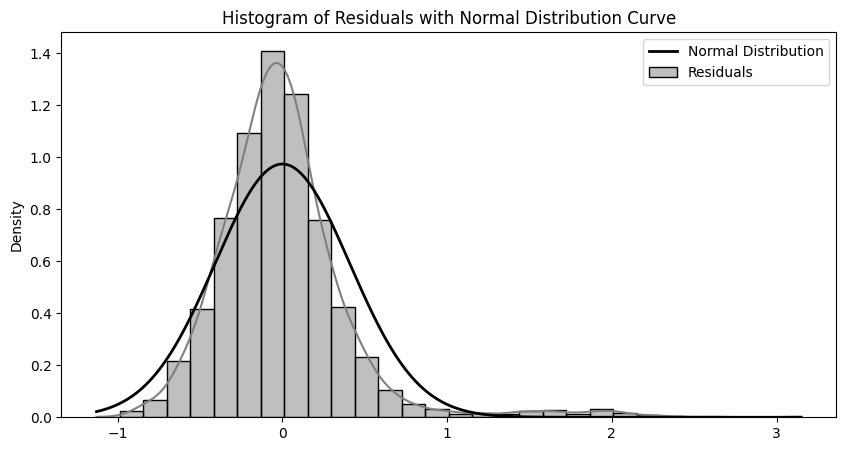

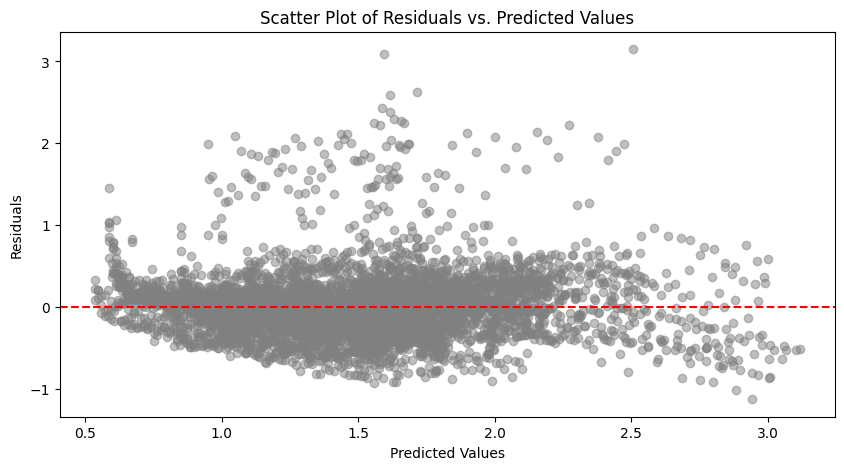

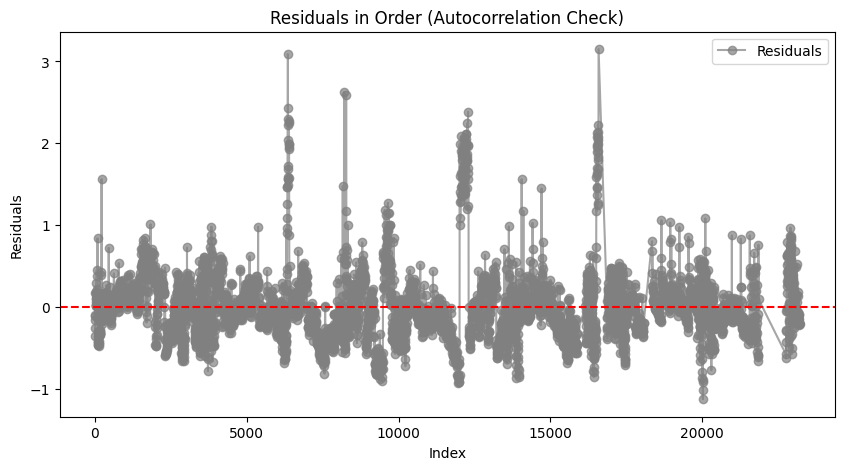

In [217]:
y_pred = model.predict(X)
residuals = y - y_pred
plot_residuals(y_pred, residuals)

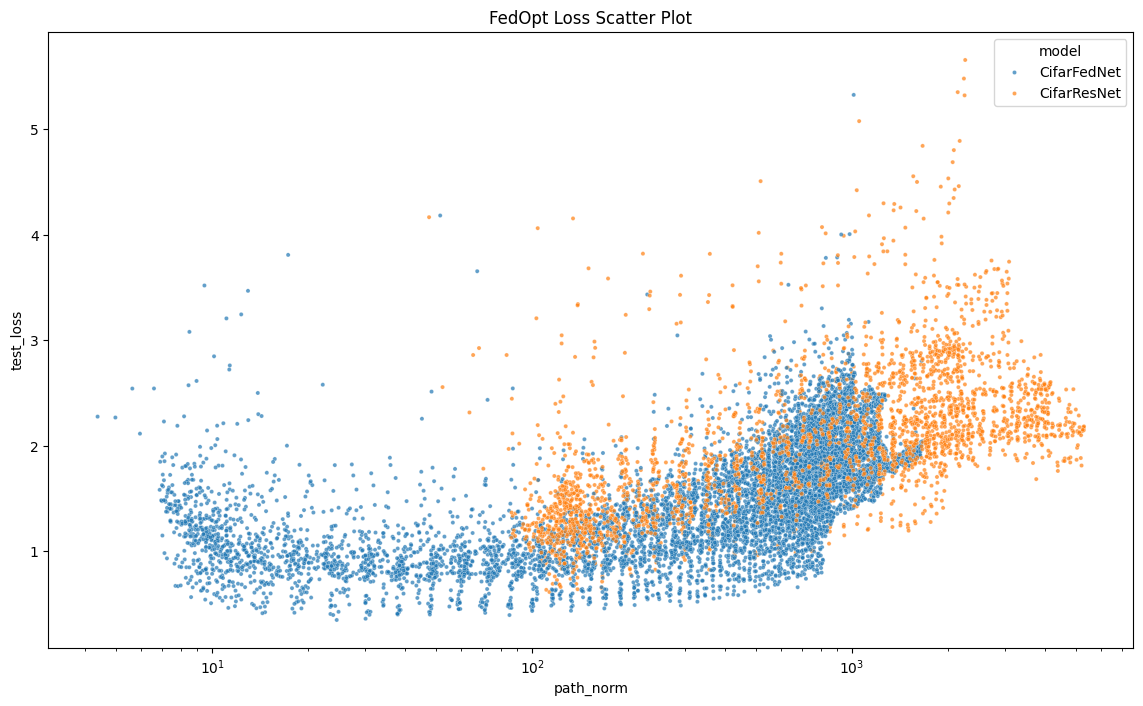

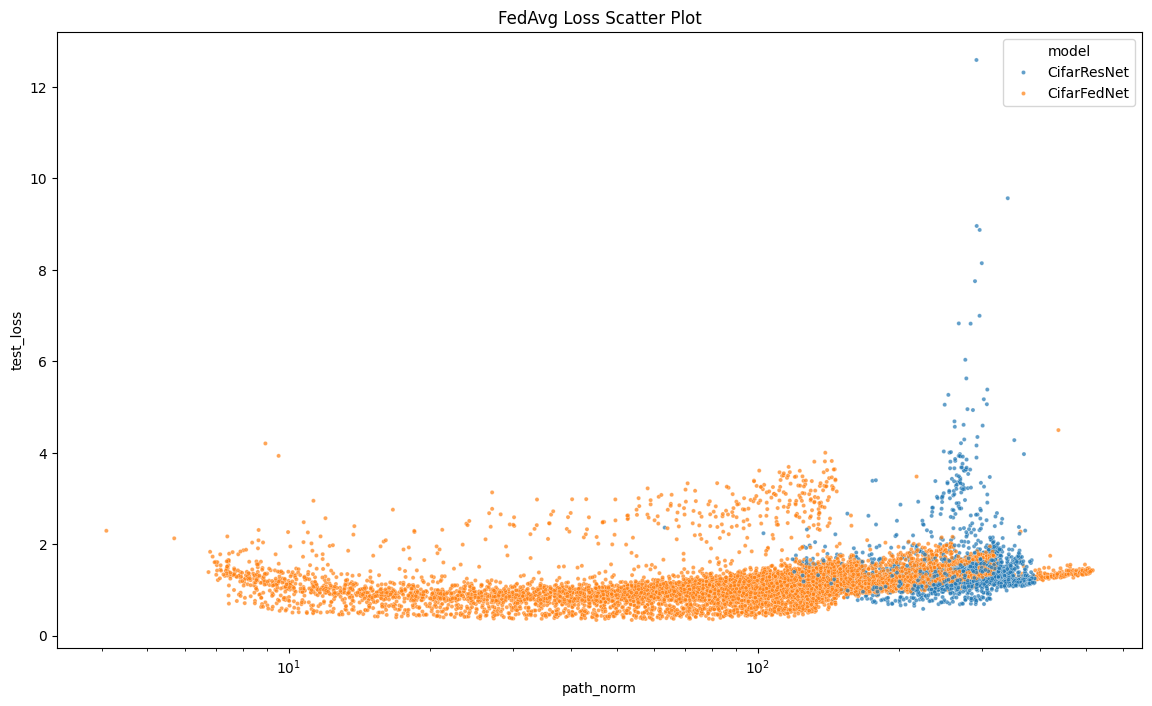

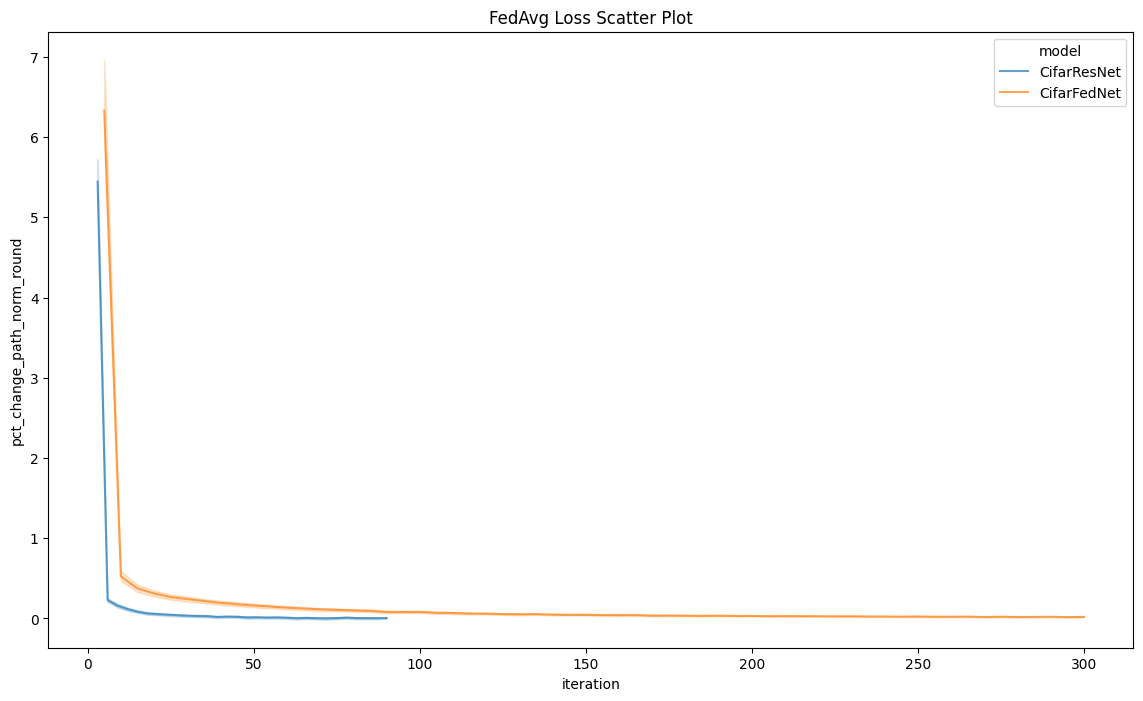

In [209]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df[df["aggregator"] == "fedopt"], x="path_norm", y="test_loss", hue="model", s=9, alpha=.7)
plt.xscale("log")
plt.title("FedOpt Loss Scatter Plot")
plt.show()

plt.figure(figsize=(14, 8))
plt.title("FedAvg Loss Scatter Plot")
plt.xscale("log")
sns.scatterplot(data=df[df["aggregator"] == "fedavg"], x="path_norm", y="test_loss", hue="model", s=9, alpha=.7)
plt.show()

plt.figure(figsize=(14, 8))
plt.title("FedAvg Loss Scatter Plot")
sns.lineplot(data=df_train[df_train["aggregator"] == "fedavg"], x="iteration", y="pct_change_path_norm_round", hue="model", alpha=.7)
plt.show()

## Explore Plain Summary Stats

In [201]:
summary = df.groupby(["iteration", "aggregator", "model", "path_norm"])["test_accuracy"].mean().reset_index()
# summary_fednet = summary[summary["model"] == "CifarFedNet"]
# summary_resnet = summary[summary["model"] == "CifarResNet"]
summary_resnet = df[df["model"] == "CifarResNet"].groupby(["iteration", "aggregator", "model", "path_norm", "gini_index", "data_count", "client_count"])["test_accuracy"].mean().reset_index()
summary_fednet = df[df["model"] == "CifarFedNet"].groupby(["iteration", "aggregator", "model", "path_norm", "gini_index", "data_count", "client_count"])["test_accuracy"].mean().reset_index()

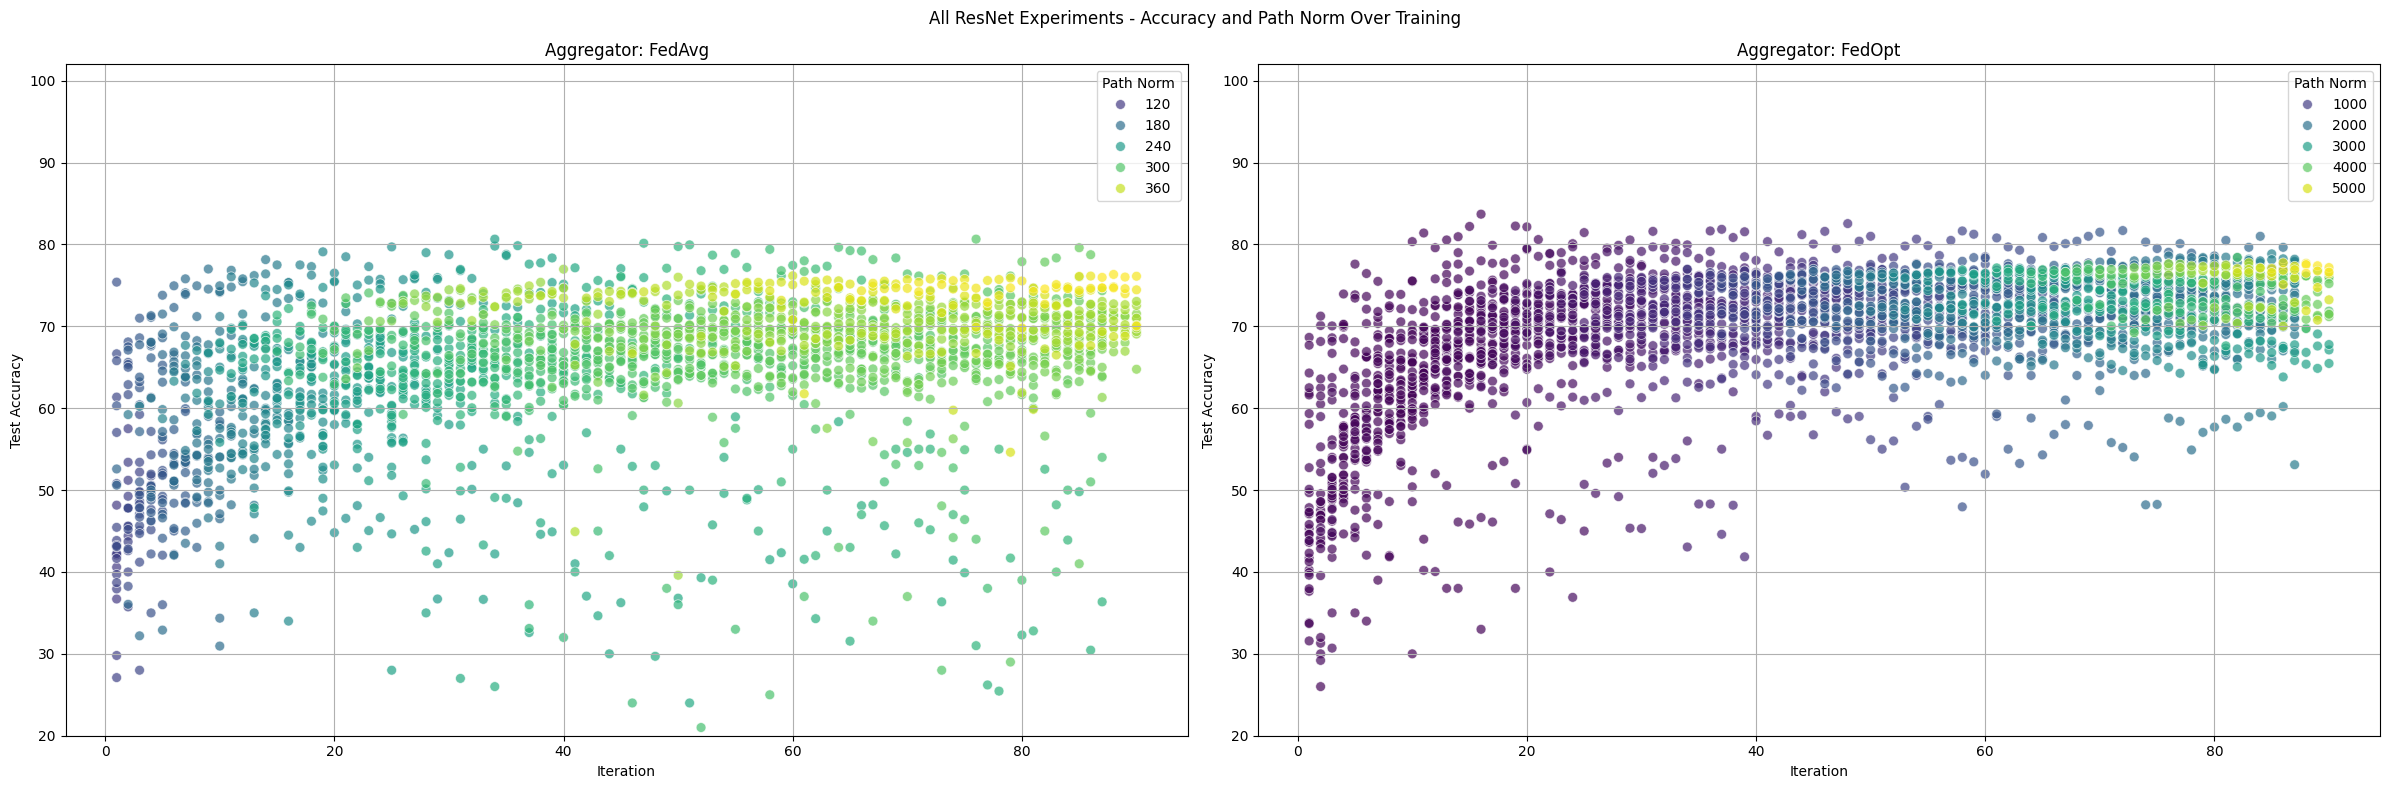

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.scatterplot(data=summary_resnet[summary_resnet["aggregator"] == "fedavg"], 
                x="iteration", y="test_accuracy", hue="path_norm", 
                palette="viridis",
                alpha=.7, s=50, ax=axes[0])
axes[0].set_title("Aggregator: FedAvg")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test Accuracy")
axes[0].set_ylim(20, 102)
axes[0].legend(title="Path Norm")
axes[0].grid(True)
sns.scatterplot(data=summary_resnet[summary_resnet["aggregator"] == "fedopt"], 
                x="iteration", y="test_accuracy", hue="path_norm", 
                palette="viridis",
                alpha=.7, s=50, ax=axes[1])
axes[1].set_title("Aggregator: FedOpt")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Test Accuracy")
axes[1].set_ylim(20, 102)
axes[1].legend(title="Path Norm")
axes[1].grid(True)
fig.suptitle("All ResNet Experiments - Accuracy and Path Norm Over Training")
plt.tight_layout()
plt.show()

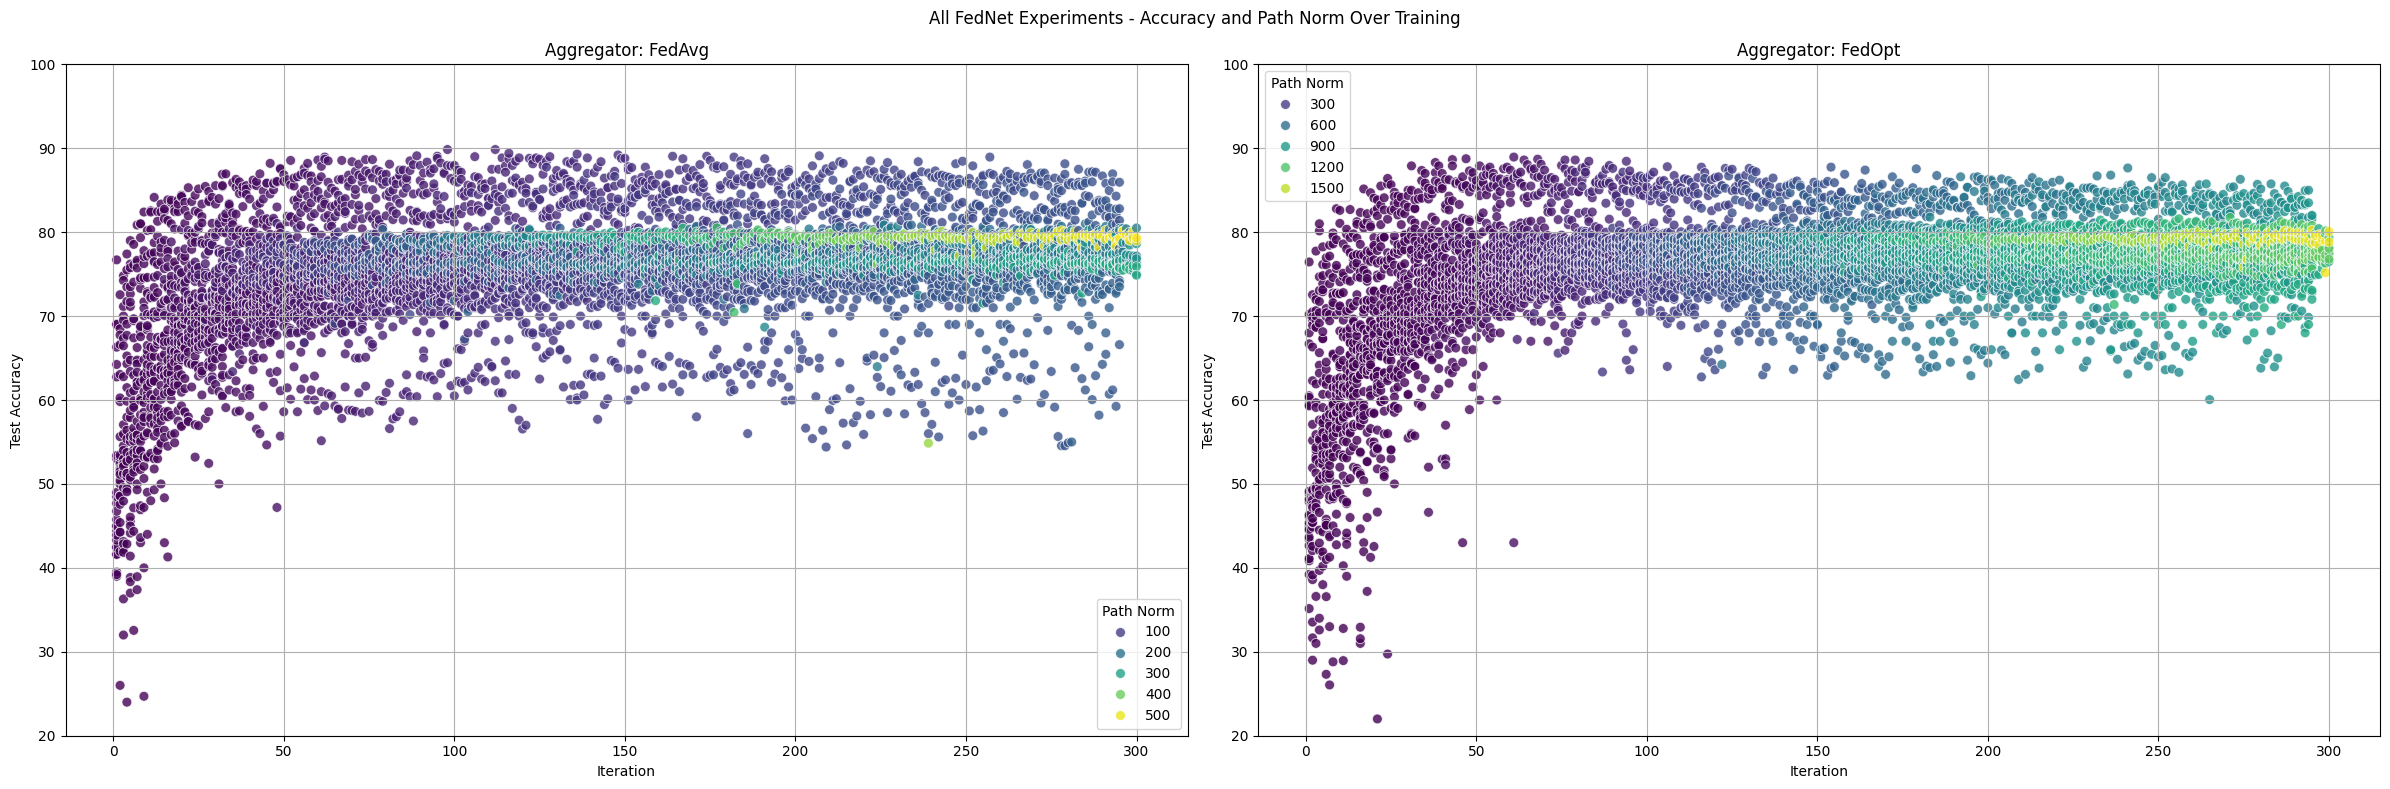

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.scatterplot(data=summary_fednet[summary_fednet["aggregator"] == "fedavg"], 
                x="iteration", y="test_accuracy", hue="path_norm", 
                palette="viridis",
                alpha=.8, s=50, ax=axes[0])
axes[0].set_title("Aggregator: FedAvg")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test Accuracy")
axes[0].set_ylim(20, 100)
axes[0].legend(title="Path Norm")
axes[0].grid(True)
sns.scatterplot(data=summary_fednet[summary_fednet["aggregator"] == "fedopt"], 
                x="iteration", y="test_accuracy", hue="path_norm", 
                palette="viridis",
                alpha=.8, s=50, ax=axes[1])
axes[1].set_title("Aggregator: FedOpt")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Test Accuracy")
axes[1].set_ylim(20, 100)
axes[1].legend(title="Path Norm")
axes[1].grid(True)
fig.suptitle("All FedNet Experiments - Accuracy and Path Norm Over Training")
plt.tight_layout()
plt.show()

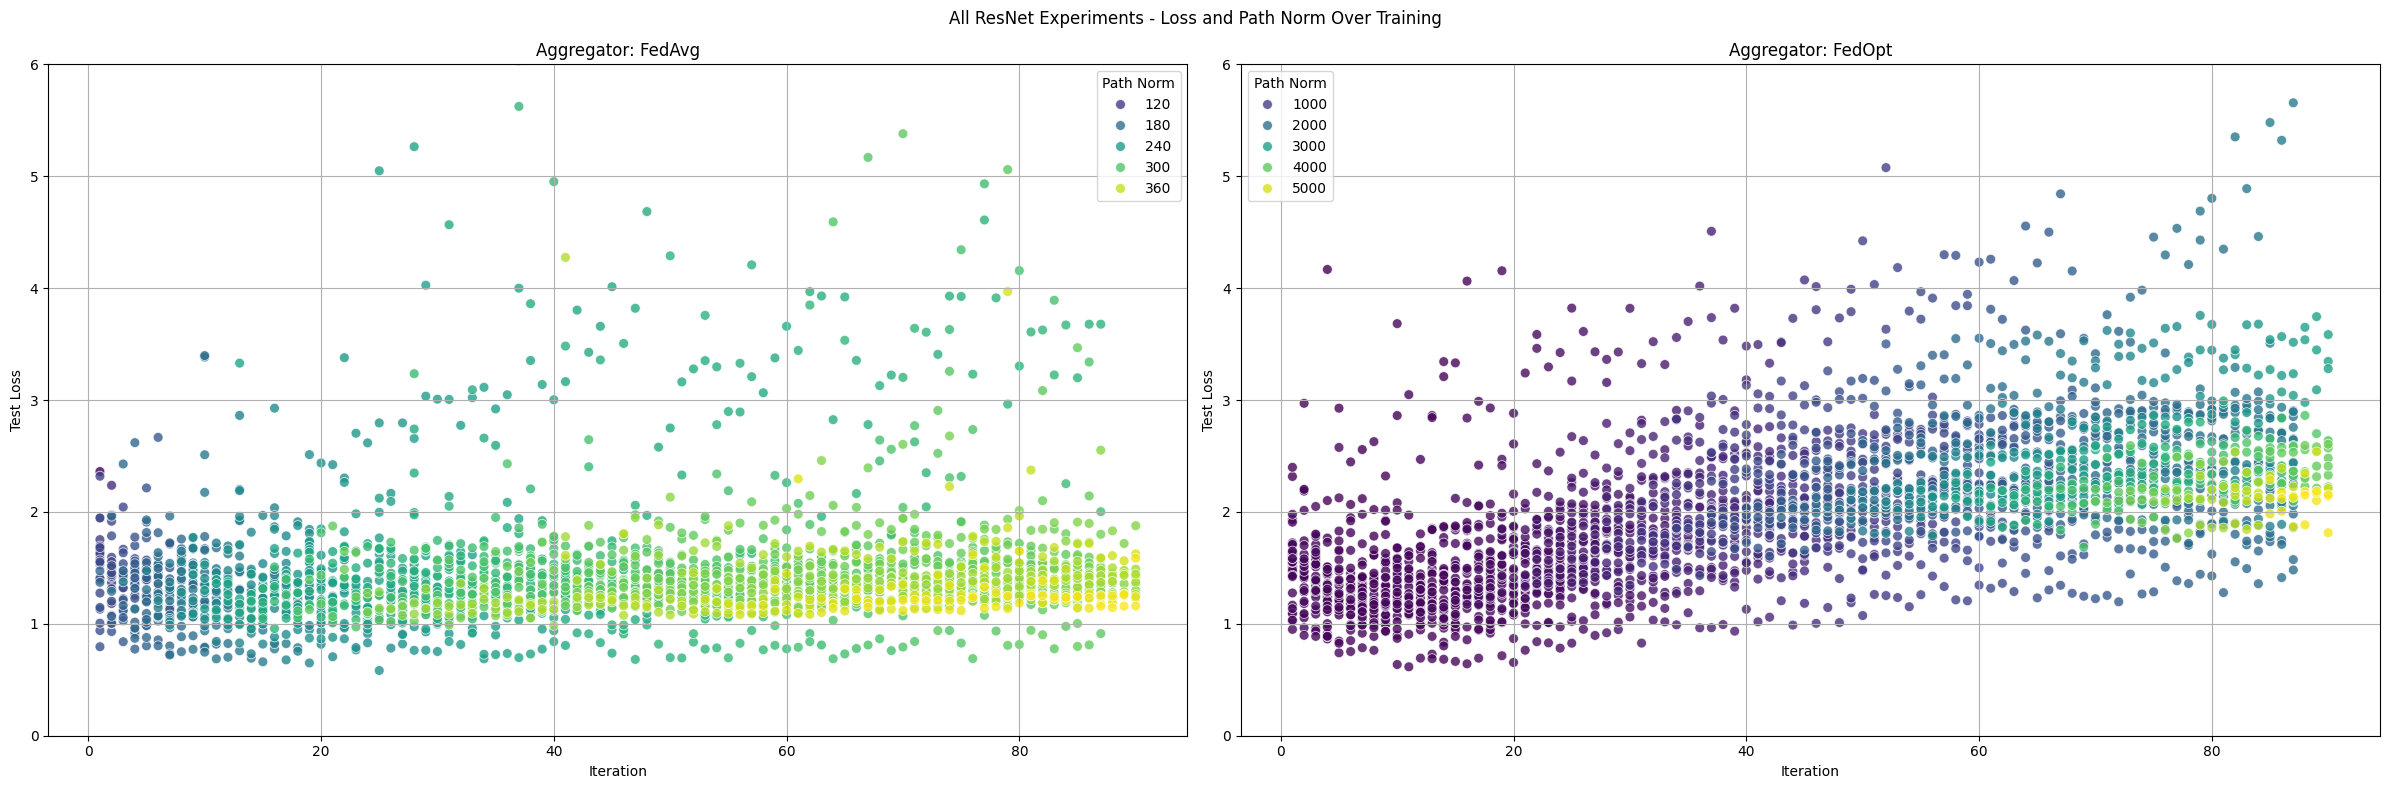

In [204]:
summary_resnet = df[df["model"] == "CifarResNet"].groupby(["iteration", "aggregator", "model", "path_norm", "gini_index"])["test_loss"].mean().reset_index()
summary_fednet = df[df["model"] == "CifarFedNet"].groupby(["iteration", "aggregator", "model", "path_norm", "gini_index"])["test_loss"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.scatterplot(data=summary_resnet[summary_resnet["aggregator"] == "fedavg"], 
                x="iteration", y="test_loss", hue="path_norm", 
                palette="viridis", s=50,
                alpha=.8, ax=axes[0])
axes[0].set_title("Aggregator: FedAvg")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test Loss")
axes[0].set_ylim(0, 6)
axes[0].legend(title="Path Norm")
axes[0].grid(True)

sns.scatterplot(data=summary_resnet[summary_resnet["aggregator"] == "fedopt"], 
                x="iteration", y="test_loss", hue="path_norm", 
                palette="viridis", s=50,
                alpha=.8, ax=axes[1])
axes[1].set_title("Aggregator: FedOpt")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Test Loss")
axes[1].set_ylim(0, 6)
axes[1].legend(title="Path Norm")
axes[1].grid(True)
fig.suptitle("All ResNet Experiments - Loss and Path Norm Over Training")
plt.tight_layout()
plt.show()

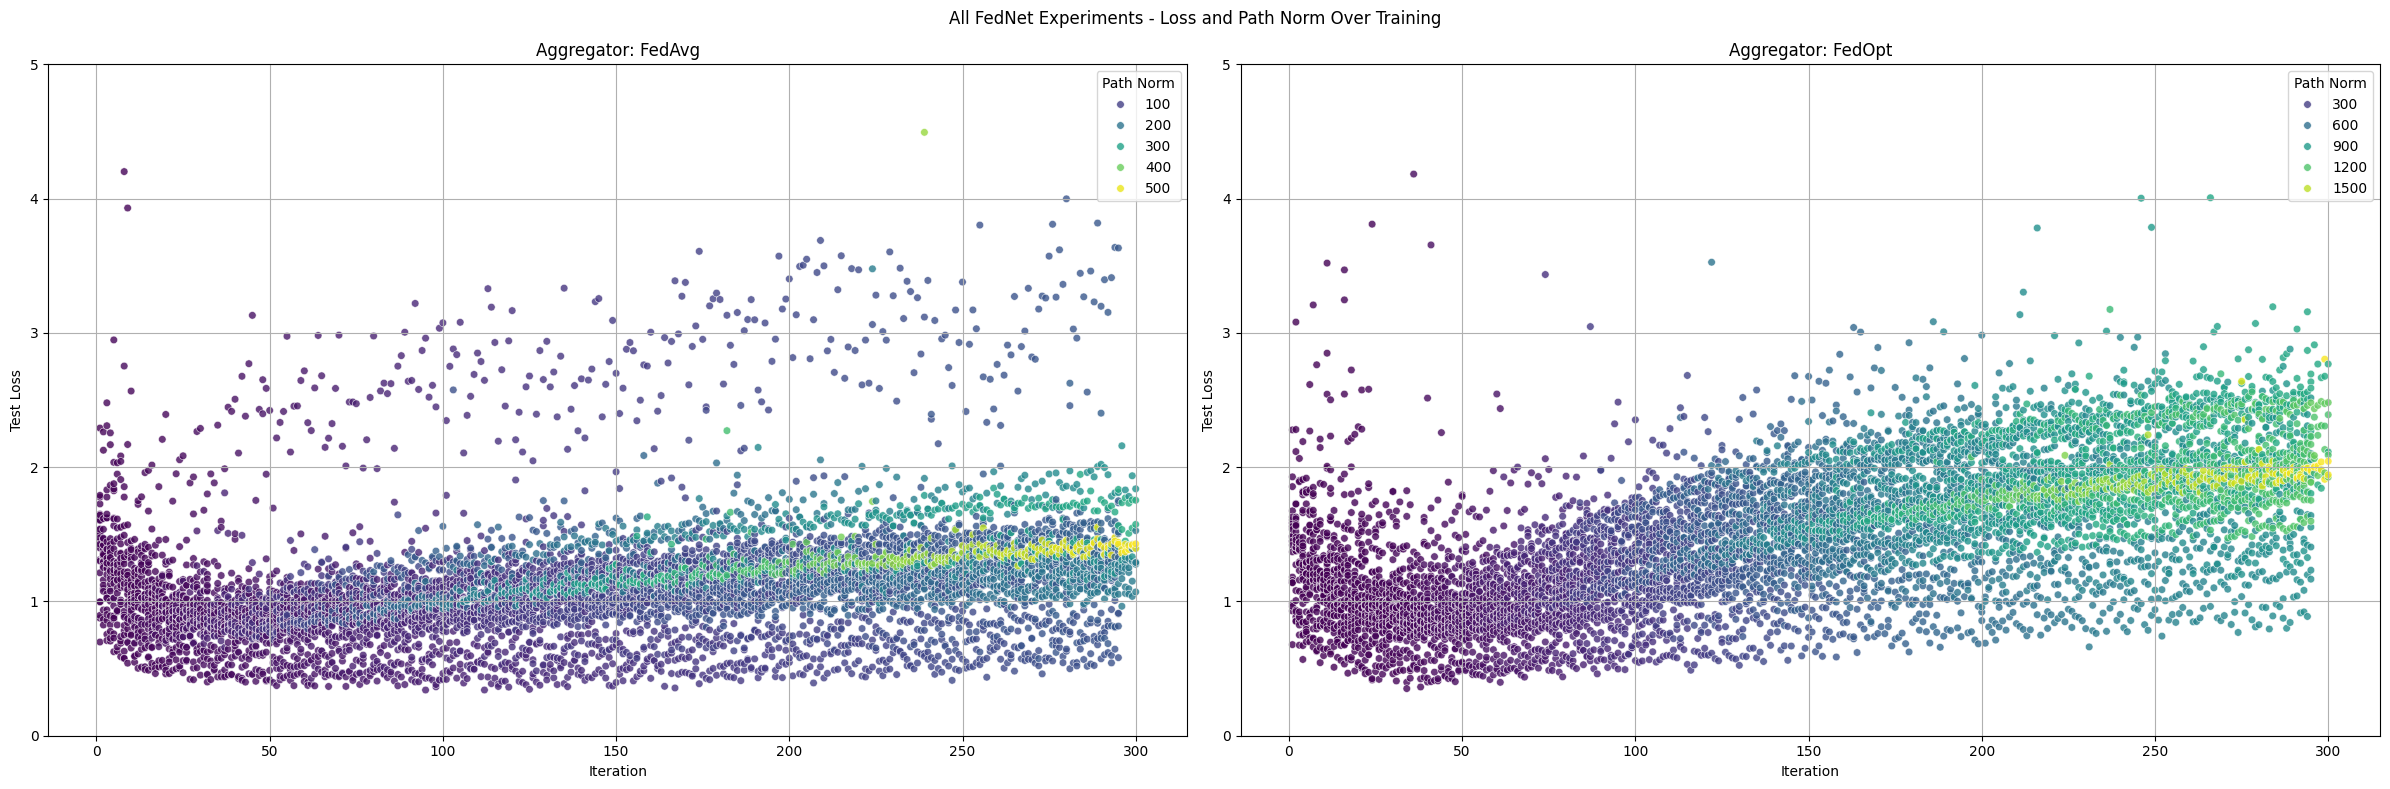

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.scatterplot(data=summary_fednet[summary_fednet["aggregator"] == "fedavg"], 
                x="iteration", y="test_loss", hue="path_norm", 
                palette="viridis",
                alpha=.8, s=30, ax=axes[0])
axes[0].set_title("Aggregator: FedAvg")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test Loss")
axes[0].set_ylim(0, 5)
axes[0].legend(title="Path Norm")
axes[0].grid(True)
sns.scatterplot(data=summary_fednet[summary_fednet["aggregator"] == "fedopt"], 
                x="iteration", y="test_loss", hue="path_norm", 
                palette="viridis",
                alpha=.8, s=30, ax=axes[1])
axes[1].set_title("Aggregator: FedOpt")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Test Loss")
axes[1].set_ylim(0, 5)
axes[1].legend(title="Path Norm")
axes[1].grid(True)
fig.suptitle("All FedNet Experiments - Loss and Path Norm Over Training")
plt.tight_layout()
plt.show()

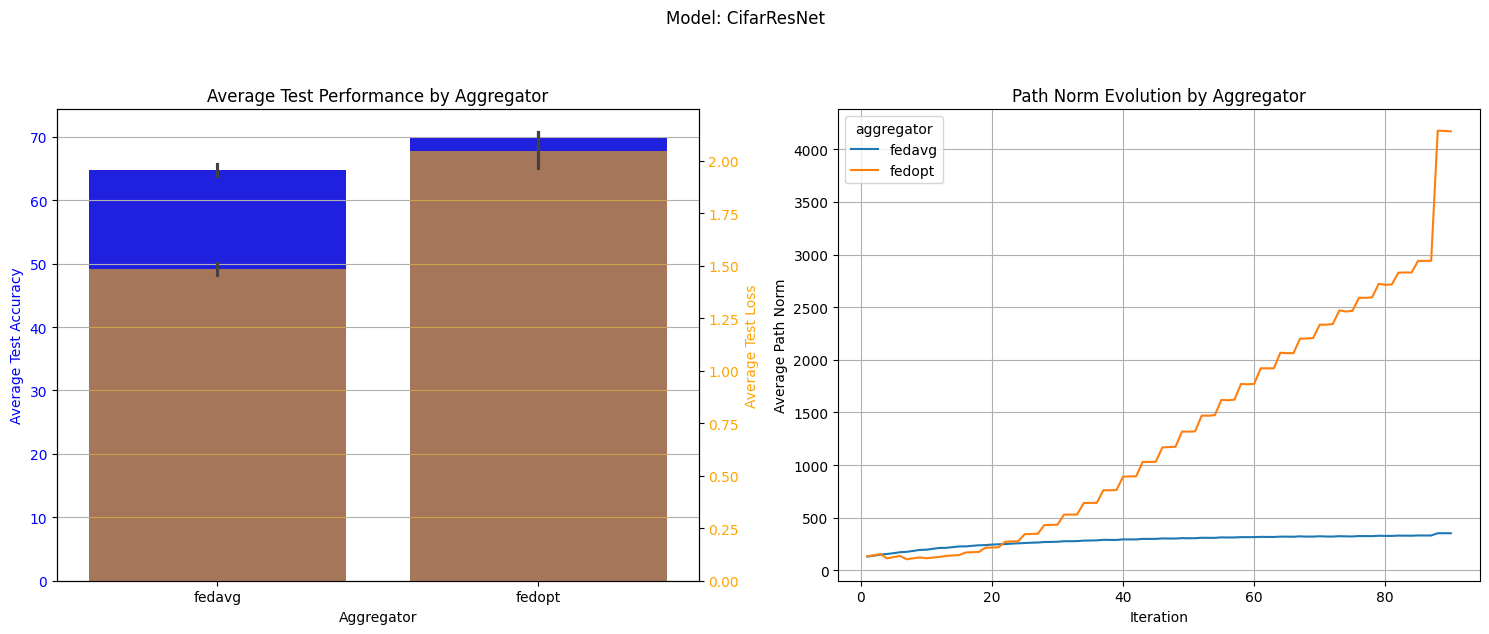


Summary Statistics for CifarResNet:
           test_accuracy         test_loss          path_norm           
                    mean     std      mean     std       mean        std
aggregator                                                              
fedavg           64.6782  9.2848    1.4868  0.7028   279.6763    58.0222
fedopt           69.7306  7.8396    2.0370  0.6683  1260.4244  1147.4585


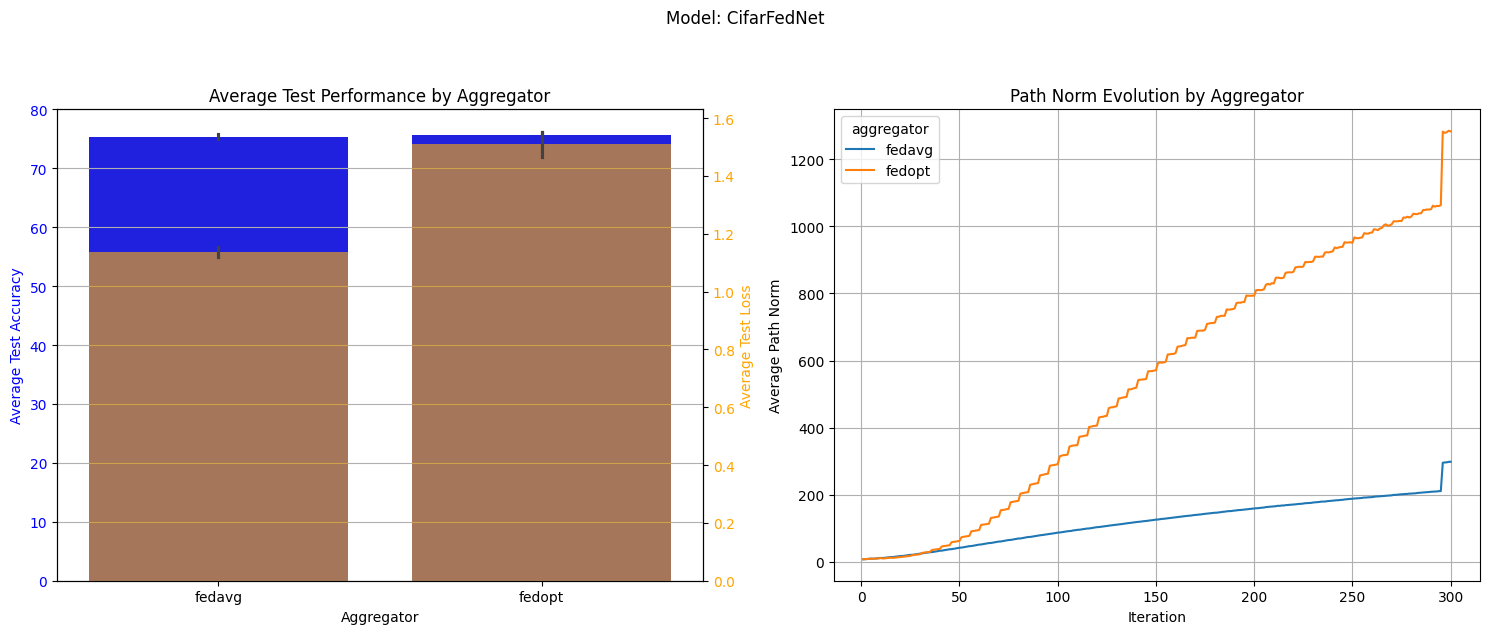


Summary Statistics for CifarFedNet:
           test_accuracy         test_loss         path_norm          
                    mean     std      mean     std      mean       std
aggregator                                                            
fedavg           75.3667  6.8676    1.1358  0.4518  118.2719   91.7640
fedopt           75.6608  6.8367    1.5023  0.5290  535.7715  389.3775


In [51]:
# Create separate plots for each model
for model_name in df["model"].unique():
   # Filter data for current model
   model_data = df[df["model"] == model_name]
   
   # Calculate metrics by aggregator for this model
   agg_metrics = model_data.groupby(["iteration", "aggregator"]).agg({
       "test_accuracy": "mean",
       "test_loss": "mean",
       "path_norm": "mean"
   }).reset_index()

   agg_metrics_melted = agg_metrics.melt(
    id_vars=["aggregator"], 
    value_vars=["test_accuracy", "test_loss"], 
    var_name="Metric", 
    value_name="Value"
   )

   # Create figure with two subplots
   plt.figure(figsize=(15, 6))
   plt.suptitle(f"Model: {model_name}", y=1.05)

   # Left subplot for test accuracy
   ax1 = plt.subplot(1, 2, 1)
   sns.barplot(
        data=agg_metrics_melted[agg_metrics_melted["Metric"] == "test_accuracy"], 
        x="aggregator", 
        y="Value", 
        ax=ax1, 
        color="blue"
    )
   ax1.set_title("Average Test Performance by Aggregator")
   ax1.set_xlabel("Aggregator")
   ax1.set_ylabel("Average Test Accuracy", color="blue")
   ax1.tick_params(axis="y", labelcolor="blue")
   ax1.grid(axis="y")

   # Add a secondary y-axis for test loss
   ax2 = ax1.twinx()
   sns.barplot(
       data=agg_metrics_melted[agg_metrics_melted["Metric"] == "test_loss"], 
       x="aggregator", 
       y="Value", 
       ax=ax2, 
       alpha=0.7, 
       color="orange"
   )
   ax2.set_ylabel("Average Test Loss", color="orange")
   ax2.tick_params(axis="y", labelcolor="orange")

   # Right subplot for path norm evolution
   plt.subplot(1, 2, 2)
   sns.lineplot(data=agg_metrics, x="iteration", y="path_norm", hue="aggregator")
   plt.title("Path Norm Evolution by Aggregator")
   plt.xlabel("Iteration")
   plt.ylabel("Average Path Norm")
   plt.grid(True)

   plt.tight_layout()
   plt.show()

   # Print summary statistics
   print(f"\nSummary Statistics for {model_name}:")
   model_stats = model_data.groupby("aggregator").agg({
       "test_accuracy": ["mean", "std"],
       "test_loss": ["mean", "std"],
       "path_norm": ["mean", "std"]
   }).round(4)
   print(model_stats)

In [52]:
agg_metrics_melted

aggregator         Metric      Value
0        fedavg  test_accuracy  48.903919
1        fedopt  test_accuracy  49.445748
2        fedavg  test_accuracy  52.881209
3        fedopt  test_accuracy  50.639575
4        fedavg  test_accuracy  54.847289
...         ...            ...        ...
1195     fedopt      test_loss   2.201863
1196     fedavg      test_loss   1.428367
1197     fedopt      test_loss   2.274652
1198     fedavg      test_loss   1.440225
1199     fedopt      test_loss   2.219758

[1200 rows x 3 columns]

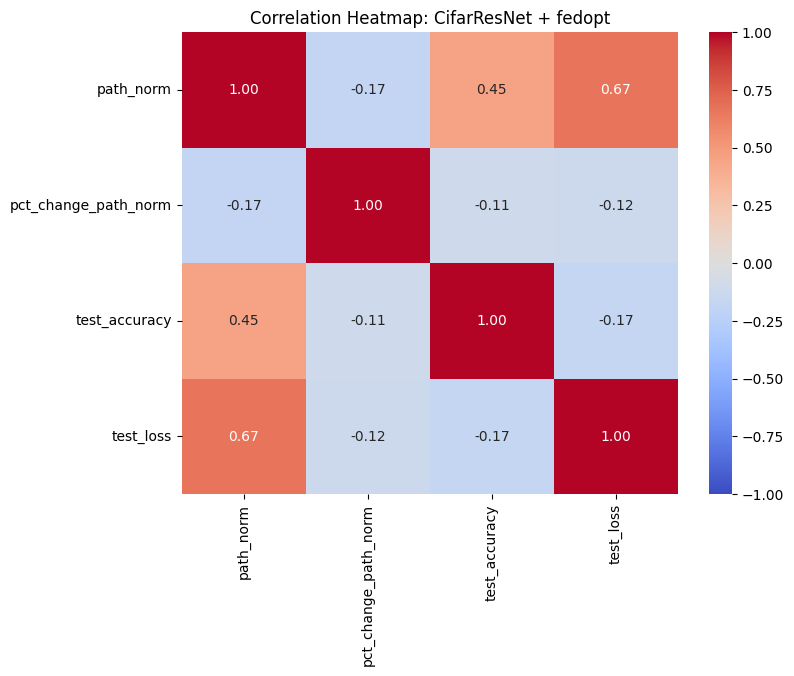

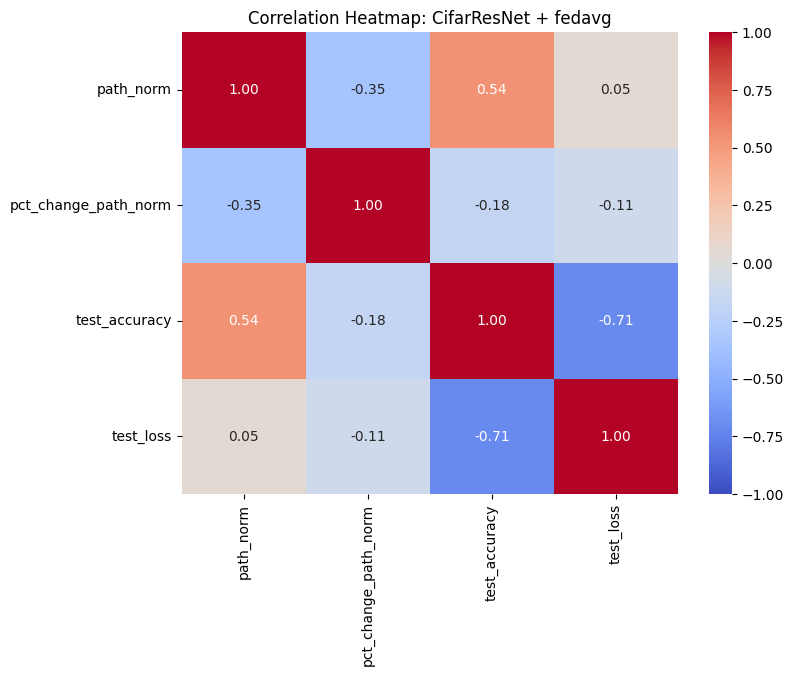

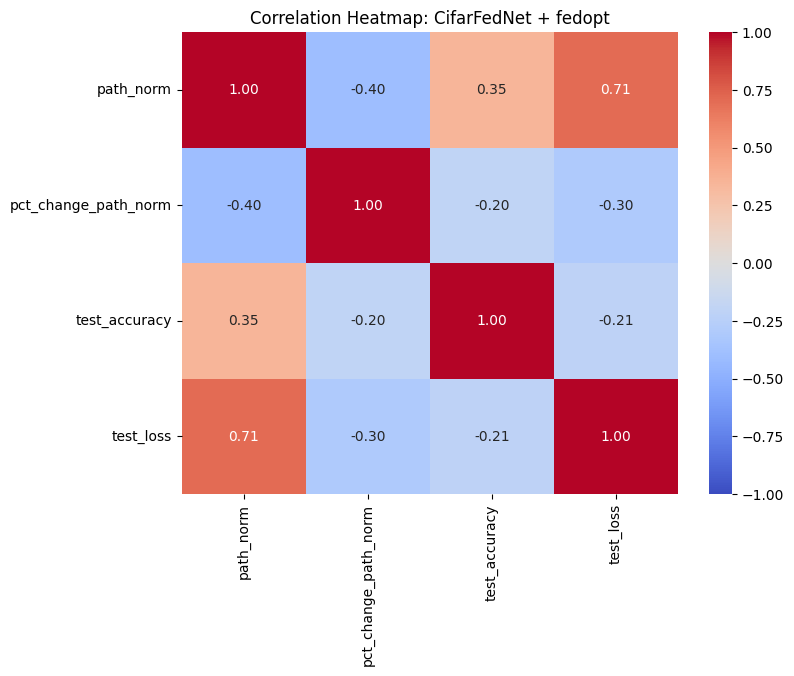

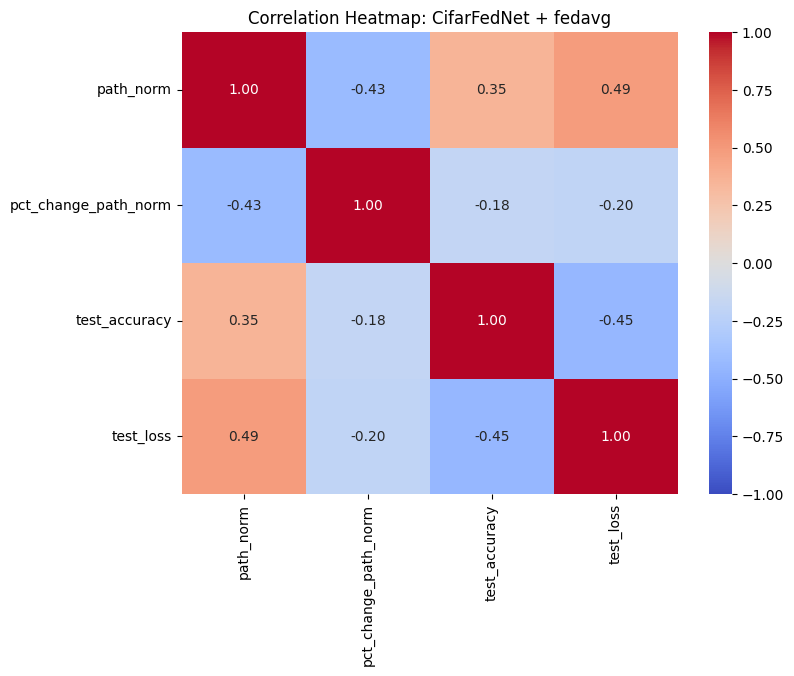

In [53]:
# model_aggregator_groups = df["experiment_id"].unique()
# for group in model_aggregator_groups:
#     subset_df = df[df["experiment_id"] == group]
#     subset_corr = subset_df[["path_norm", "test_accuracy", "test_loss"]].corr()

#     exp_name = get_experiment_description(experiment_id=group, results_path="../results")
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(subset_corr, annot=True, cmap="coolwarm", fmt=".3f", vmin=-1, vmax=1)
#     plt.title(f"Correlation Matrix for {exp_name}")
#     plt.show()
combinations = [
    ("CifarResNet", "fedopt"),
    ("CifarResNet", "fedavg"),
    ("CifarFedNet", "fedopt"),
    ("CifarFedNet", "fedavg")
]

for model, aggregator in combinations:
    subset_df = df[(df["model"] == model) & (df["aggregator"] == aggregator)]
    subset_corr = subset_df[["path_norm", "pct_change_path_norm", "test_accuracy", "test_loss"]].corr(method="spearman")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(subset_corr, annot=True, cmap="coolwarm", fmt=".2f", 
                cbar=True, vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap: {model} + {aggregator}")
    plt.show()

In [39]:
df.head()

index  epoch  learning_rate  batch_size  len_train_indices  \
0      0      0           0.01          32              25000   
1      1      1           0.01          32              25000   
2      2      2           0.01          32              25000   
3      3      0           0.01          32              25000   
4      4      1           0.01          32              25000   

   len_test_indices  momentum  train_loss  train_accuracy  test_loss  ...  \
0              5000       0.5    1.137054          61.964   1.274805  ...   
1              5000       0.5    0.800697          74.136   1.073673  ...   
2              5000       0.5    0.592440          81.296   1.116475  ...   
3              5000       0.5    0.503616          84.064   2.619152  ...   
4              5000       0.5    0.393668          87.916   1.038320  ...   

   pct_change_path_norm  diff_path_norm  pct_change_global_path_norm  \
0                   NaN             NaN                          NaN   
1              0.078335       10.561339                     0.000000   
2              0.077635       11.286839                     0.000000   
3              0.098161       15.379023                     5.875526   
4              0.039216        6.747105                     0.000000   

  diff_global_path_norm  gini_index data_count  aggregator        model  \
0                   NaN    0.492296      25000      fedavg  CifarResNet   
1              0.000000    0.492296      25000      fedavg  CifarResNet   
2              0.000000    0.492296      25000      fedavg  CifarResNet   
3            136.003236    0.492296      25000      fedavg  CifarResNet   
4              0.000000    0.492296      25000      fedavg  CifarResNet   

   client_count  iteration  
0             2          1  
1             2          2  
2             2          3  
3             2          4  
4             2          5  

[5 rows x 26 columns]

In [40]:
df[df["test_accuracy"] == 100].groupby("experiment_id").describe()

index                               \
                                     count       mean  min    25%   50%   
experiment_id                                                             
9a0fe8d3-8506-4157-ab61-291fc6d9c38d  90.0  44.500000  0.0  22.25  44.5   
a97f0e29-0262-4eb9-a117-f08f25a3a2b1  41.0  32.975610  0.0  10.00  26.0   
bb3aa1b6-db01-4610-9689-9d0101e92d17  15.0   7.000000  0.0   3.50   7.0   
e6c4fbe6-b338-4ddb-9994-eb3097535278  53.0  31.037736  0.0  13.00  26.0   

                                                             epoch            \
                                        75%   max        std count      mean   
experiment_id                                                                  
9a0fe8d3-8506-4157-ab61-291fc6d9c38d  66.75  89.0  26.124701  90.0  1.000000   
a97f0e29-0262-4eb9-a117-f08f25a3a2b1  56.00  89.0  26.730589  41.0  1.219512   
bb3aa1b6-db01-4610-9689-9d0101e92d17  10.50  14.0   4.472136  15.0  1.000000   
e6c4fbe6-b338-4ddb-9994-eb3097535278  40.00  94.0  25.056829  53.0  2.075472   

                                      ... client_count      iteration  \
                                      ...          max  std     count   
experiment_id                         ...                               
9a0fe8d3-8506-4157-ab61-291fc6d9c38d  ...          3.0  0.0      90.0   
a97f0e29-0262-4eb9-a117-f08f25a3a2b1  ...          3.0  0.0      41.0   
bb3aa1b6-db01-4610-9689-9d0101e92d17  ...          3.0  0.0      15.0   
e6c4fbe6-b338-4ddb-9994-eb3097535278  ...          3.0  0.0      53.0   

                                                                          \
                                           mean  min    25%   50%    75%   
experiment_id                                                              
9a0fe8d3-8506-4157-ab61-291fc6d9c38d  45.500000  1.0  23.25  45.5  67.75   
a97f0e29-0262-4eb9-a117-f08f25a3a2b1  33.975610  1.0  11.00  27.0  57.00   
bb3aa1b6-db01-4610-9689-9d0101e92d17   8.000000  1.0   4.50   8.0  11.50   
e6c4fbe6-b338-4ddb-9994-eb3097535278  32.037736  1.0  14.00  27.0  41.00   

                                                       
                                       max        std  
experiment_id                                          
9a0fe8d3-8506-4157-ab61-291fc6d9c38d  90.0  26.124701  
a97f0e29-0262-4eb9-a117-f08f25a3a2b1  90.0  26.730589  
bb3aa1b6-db01-4610-9689-9d0101e92d17  15.0   4.472136  
e6c4fbe6-b338-4ddb-9994-eb3097535278  95.0  25.056829  

[4 rows x 184 columns]

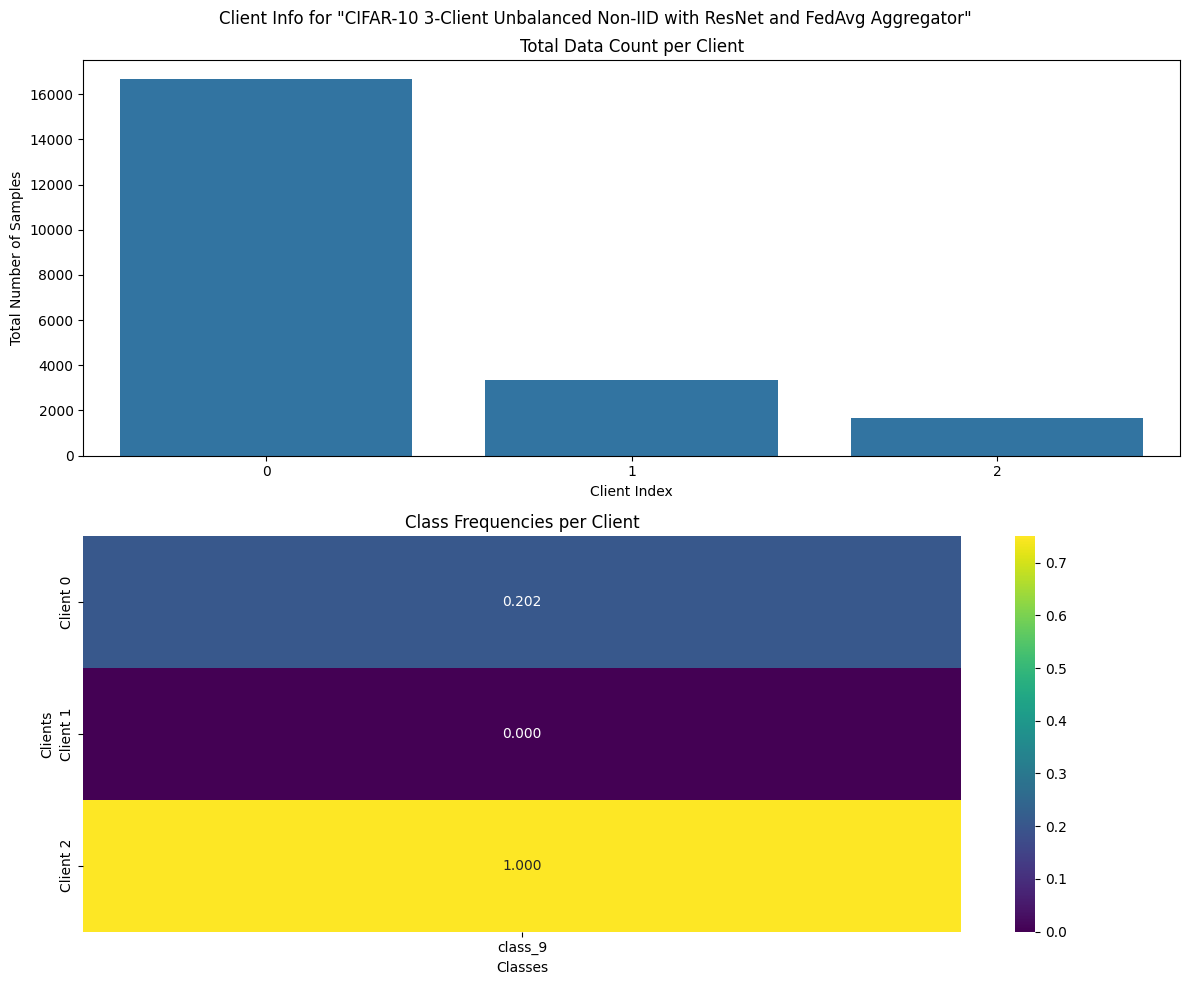

In [17]:
from fedland.utils import plot_client_info
plot_client_info("9a0fe8d3-8506-4157-ab61-291fc6d9c38d", results_path="../results")